# Classifying Toxic Comments

In this project we are downloading a dataset from kaggle.  A Civil Comments platform which shutdown in 2017 releasing their ~2million comments to the general public which we are going to use to classify toxicity

First we import required packages to preprocess the text in a pandas dataframe and load in the data from the csv file.  Our data has many columns but the only ones we're going to look at is the comment text and the target.  This data has been originally labeled for how toxic a comment is on a scale from 0-1.  We make a binary class from the target column with `<0.5` being labeled as 0 (Not Toxic) and `>=0.5` being labeled as a 1 (toxic).

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve

//anaconda3/envs/metis/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
df = pd.read_csv('/Users/luken2/Documents/GitHub/toxicity/data/train.csv')

In [ ]:
df = df[['target', 'comment_text']]

In [ ]:
df['comment_text'] = df['comment_text'].astype(str)

In [ ]:
def class_labels(column):
    """
    Takes in target column and creates list of binary values. 1 (>=0.5) being in the 
    positive class (toxic), 0 (<0.5) being in the negative class (Not toxic)
    """
    class_label = []
    
    for row in column:
        
        if row < 0.5:
            class_label.append(0)
        else:
            class_label.append(1)
            
    return class_label

In [ ]:
df['class'] = class_labels(df['target'])

## Preprocessing
For preprocessing we are going to do the following and save the results of each step in a new column in our dataframe to make it easy to go back to a certain step if further preprocessing is required
1. Remove unwanted characters from the text
2. Tokenize the text
3. Remove stopwords and contractions
4. Part of speech tagging
5. Lemmatization

### Remove unwanted characters from the text

In [ ]:
def clean_text(df, text):
    """
    Cleans text by replacing unwanted characters with blanks
    Replaces @ signs with word at
    Makes all text lowercase
    """
    df[text] = df[text].str.replace(r'[^A-Za-z0-9()!?@\s\'\`\*\"\_\n]', '')
    df[text] = df[text].str.replace(r'@', 'at')
    df[text] = df[text].str.lower()
    
    return df

In [ ]:
clean_text(df, 'comment_text')

### Tokenize the text
We will tokenize in 1-grams for now.  We can easily go back and tokenize in N-grams if needed

In [ ]:
tokenizer = RegexpTokenizer(r'\w+\'*[a-zA-Z]+')
df['tokens'] = df['comment_text'].apply(tokenizer.tokenize)
df.head()

### Remove stopwords and contractions
We add list of contractions to our list of stopwords to effectively remove them as well.  This is done with a single apply and lambda function

In [ ]:
stopwords = ["ain't", "aren't", "can't", "can't've", "'cause", "could've", "couldn't", "couldn't've", "didn't", "doesn't", "don't", "hadn't", "hadn't've", "hasn't", "haven't", "he'd", "he'd've", "he'll", "he'll've", "he's", "how'd", "how'd'y", "how'll", "how's", "i'd", "i'd've", "i'll", "i'll've", "i'm", "i've", "isn't", "it'd", "it'd've", "it'll", "it'll've", "it's", "let's", "ma'am", "mayn't", "might've", "mightn't", "mightn't've", "must've", "mustn't", "mustn't've", "needn't", "needn't've", "o'clock", "oughtn't", "oughtn't've", "shan't", "sha'n't", "shan't've", "she'd", "she'd've", "she'll", "she'll've", "she's", "should've", "shouldn't", "shouldn't've", "so've", "so's", "that'd", "that'd've", "that's", "there'd", "there'd've", "there's", "they'd", "they'd've", "they'll", "they'll've", "they're", "they've", "to've", "wasn't", "we'd", "we'd've", "we'll", "we'll've", "we're", "we've", "weren't", "what'll", "what'll've", "what're", "what's", "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", "who'll've", "who's", "who've", "why's", "why've", "will've", "won't", "won't've", "would've", "wouldn't", "wouldn't've", "y'all", "y'all'd", "y'all'd've", "y'all're", "y'all've", "you'd", "you'd've", "you'll", "you'll've", "you're", "you've", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]
df['no_stopwords'] = df['tokens'].apply(lambda x: [(item for item in x if item not in stopwords)])
df.head()

### Part of speech tagging
We are speech tagging with nltk and then converting the speech tags to wordnet speech tags because lemmatizing is only compatible with wordnet.  We accomplish this with a couple apply's and a function to convert speech tags to wordnet

In [ ]:
df['speech_tags'] = df['no_stopwords'].progress_apply(pos_tag)

In [ ]:
def wordnet_pos(tag):
    from nltk.corpus import wordnet
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
df['wordnet_pos'] = df['speech_tags'].progress_apply(lambda x: 
                                     [(word, wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df.head()

### Lemmatization
We lemmatize to make words like 'having' and 'have' into one word.  This can be done in a single apply and lambda function and we'll save our progress here with a pickle

In [ ]:
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['wordnet_pos'].progress_apply(lambda x: 
                                    [lemmatizer.lemmatize(word, tag) for (word, tag) in x])
df.head()

In [ ]:
df.to_pickle('/Users/luken2/Documents/GitHub/toxicity/data/train_cleaned.pickle')

In [3]:
df = pd.read_pickle('/Users/luken2/Documents/GitHub/toxicity/data/train_cleaned.pickle')

Let's learn a little more about our data.  We are going to calculate the amount of words in our lemmatized column and our vocabulary (Unique Words).  Also, it might be helpful to know how long our longest sentence is

In [4]:
words = [word for row in df['lemmatized'] for word in row]
vocab = list(set(words))
sentence_lengths = [len(sentence) for sentence in df['lemmatized']]
print('Total Words: ', len(words))
print('Unique Words: ', len(vocab))
print('Longest Sentence: ', max(sentence_lengths), 'words')

Total Words:  42157140
Unique Words:  588800
Longest Sentence:  304 words


In [5]:
df['class'].value_counts()

0    1660540
1     144334
Name: class, dtype: int64

In [48]:
X = df['lemmatized']
y = df['class']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

## Minimal Viable Product
To create our minimal viable product we are going to do the following and plot the results and look at our most important words for each category. We will train_test_split and use cross validation on a variety of metrics to measure our performance
1. Embedding (CountVectorizer)
2. Dimensionality Reduction (LSA)
3. Logistic Regression and evaluation
4. Inspection

### Count Vectorizer
CountVectorizer uses One-Hot Enconding to create a bag of words embedding for all words in your text.  It has built in preprocessing parameters but we already did preprocessing so we are going to call a dummy function in our CountVectorizer function to skip its self-initiated preprocessing 

In [49]:
def count_vectorize(text_tokens):
    """
    Gives text data in tokenized form to create bag of words
    with CountVectorizer.  Returns bag of words and vectorizer 
    fitted to tokened data
    """
    from sklearn.feature_extraction.text import CountVectorizer
    
    def dummy(doc):
        """
        Used since text data is already tokenized and preprocessed
        """
        return doc
    
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy, token_pattern=None)
    
    bag = cv.fit_transform(text_tokens)
    
    return bag, cv

In [50]:
X_train_cv, cv = count_vectorize(X_train)
X_val_cv = cv.transform(X_val)

### Dimensionality Reduction (LSA)
We are using LSA on vectorized data.  LSA performs SVD and is the equivalent of PCA for text data.  We'll use a function to perform this task for us.  We will plot our data in 2 dimensions to see if there is any seperation between our classes

In [51]:
def plot_lsa(vectorized_words, class_labels):
    """
    Plots embedded words in two dimensions with color based on class
    """
    from sklearn.decomposition import TruncatedSVD
    
    # We are using 2 dimensions for visualization
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(vectorized_words)
    lsa_scores = lsa.transform(vectorized_words)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=4, c=class_labels, alpha=0.5)
   
    plt.show()

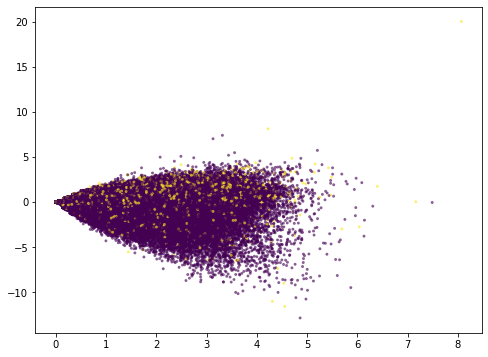

In [52]:
plot_lsa(X_train_cv, y_train)

All of our points are relatively close together and our classes are not very well seperated.  Let's see how well a model performs classifying our data

### Logistic Regression
Let's start off with a simple logistic regression model because it's computation cost is low and it is relatively easy to explain.  We will judge our model with
1. Accuracy
2. F1_Score
3. Precision
4. Recall
5. Roc_auc_Score

In [11]:
clf = LogisticRegression(C=3, solver='sag', n_jobs=-1, random_state=42)
clf.fit(X_train_cv, y_train)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [12]:
def evaluate_model(y_true, y_predicted):
    """
    performs cross validation of a model given training data by 
    taking the mean of 4 cross-validation scores
    """

    accuracy = accuracy_score(y_true, y_predicted)
    
    precision = precision_score(y_true, y_predicted)
    
    recall = recall_score(y_true, y_predicted)
    
    f1 = f1_score(y_true, y_predicted)
    
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('f1_score: ', f1)

In [13]:
evaluate_model(y_val, clf.predict(X_val_cv))

Accuracy:  0.9405277373779347
Precision:  0.780853262474166
Recall:  0.3638145677144233
f1_score:  0.4963637216722188


In [14]:
def roc_curve_plot(y_true, y_predicted_proba, y_predicted):
    """
    Creates roc curve given true y values and 
    a model's predicted probabilities and predicted class
    """
    fpr, tpr, thr = roc_curve(y_true, y_predicted_proba[:,1])
    auc = roc_auc_score(y_true, y_predicted)
    lw = 2
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Area Under Curve = %0.3f" % auc)
    plt.plot(y_true, y_true, color='green', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Plot')
    plt.legend(loc="lower right")
    plt.show()

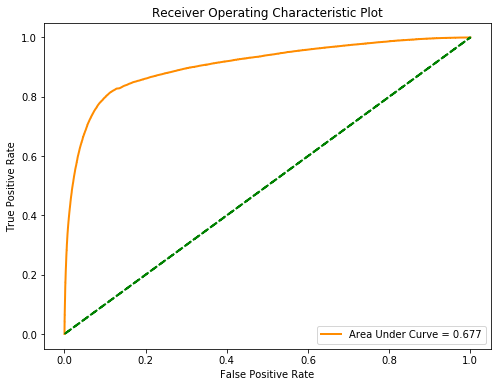

In [15]:
roc_curve_plot(y_val, clf.predict_proba(X_val_cv), clf.predict(X_val_cv))

So our model's accuracy is pretty good but since we have class imbalance this might not be the best measure.  As we can see with the roc_curve_plot we have some room to improve.  But this is not bad for a MVP.

### Inspection
Now lets look at the confusion matrix and feature importances to better understand our model.  We are going to plot the most important words our model is using to classify the postiive class to see if our model is making informative decisions

In [16]:
def make_confusion_matrix(y_true, y_predicted):
    """
    Makes confusion matrix heatmap.
    y_true: True class values
    y_predicted: Predicted class values
    """

    confusion = confusion_matrix(y_true, y_predicted)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.winter, annot=True, square=True, fmt='d',
           xticklabels=['Irrelavant', 'Toxic'],
           yticklabels=['Irrelavant', 'Toxic']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    print(confusion)

[[328928   2969]
 [ 18499  10579]]


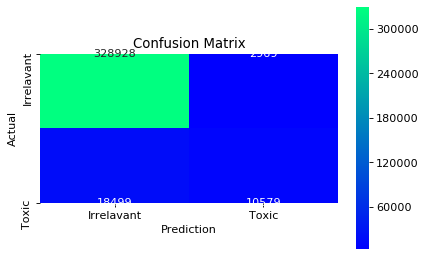

In [17]:
make_confusion_matrix(y_val, clf.predict(X_val_cv))

In [18]:
def most_important_words(vectorizer, model, number):
    """
    Plots a horizontal bar graph of the top n most important words for a given vectorizer
    and a model fitted to data.
    number is number of words wanted
    """
    word_indices = {word:index for index,word in vectorizer.vocabulary_.items()}

# Stores each (word and importance) in a tuple that our model used for classifying each class
    word_importance = [[importance, word_indices[index]] for index,
                           importance in enumerate(model.coef_[0])]
    
# Sorts the list above so the words with the highest importance are first
    most_important_words = sorted(word_importance, key = lambda x: x[0], reverse=True)
    
    values = np.array(most_important_words)[:number, 0]
    words = np.array(most_important_words)[:number, 1]
    
    values_list = []
    for value in values:
        values_list.append(value)
    values_list.reverse()
    words_list = []
    for word in words:
        words_list.append(word)
    words_list.reverse()
    
    plt.figure(figsize=(8,6))
    plt.barh(words_list, values_list, align='center', alpha=0.5)
    plt.title('Important Words')
    plt.xticks(rotation=65)
    plt.show()

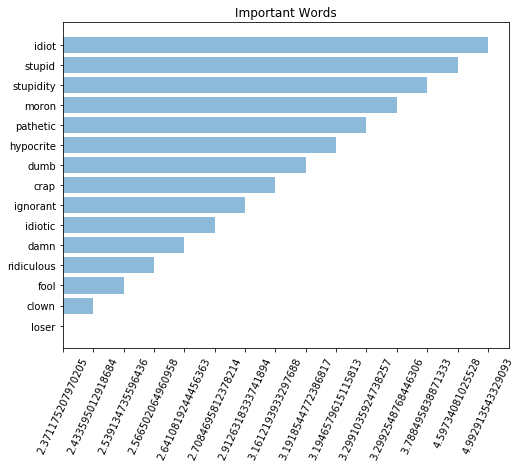

In [19]:
most_important_words(cv, clf, 15)

These are the 15 words our model is using the most to classify toxic comments.  Most of these words make sense but it seems we are over fitting a little with the word 'down'.  Also all the weights its giving to words are relatively low so our model might not be picking up on which words are worse than others

## TF-IDF Vectorizer
Let's see if we can improve our model by using a different word embedding and going through the same steps as above
1. Embedding (Tf-Idf Vectorize)
2. Dimensionality Reduction (LSA)
3. Logistic Regression and evaluation
4. Inspection


### Tf-Idf Vectorize
We are vectorizing our 'lemmatized' column using sklearn's TfidfVectorizer.  This will give more meaning to more important words by assigning weight to words that appear less. Since our text is already preprocessed we use a dummy function as arguments in the vectorizer to skip it's self-initiated preprocessing

In [20]:
def tf_idf(text_tokens):
    """
    Gives text data in tokenized form to create bag of words
    with tf-idf.  Returns bag of words and vectorizer.
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    def dummy(doc):
        """
        Used since text data is already tokenized and preprocessed
        """
        return doc
    
    tf = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, token_pattern=None)
    
    bag = tf.fit_transform(text_tokens)
    
    return bag, tf

In [21]:
X_train_tf, tf = tf_idf(X_train)
X_val_tf = tf.transform(X_val)

### Dimensionality Reduction (LSA)
Our data visualized in 2 dimensions with TF-IDF embeddings look a lot more spread out than it did with CountVectorizer. Our classes still dont look well seperated.

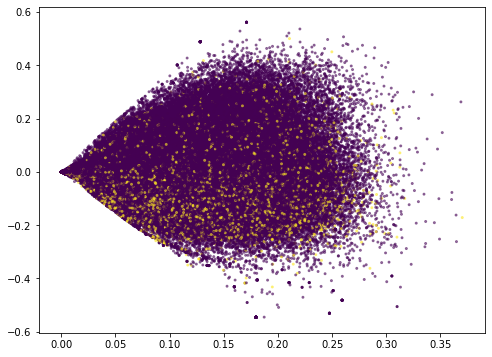

In [22]:
plot_lsa(X_train_tf, y_train)

### Logistic Regression
We are going to fit a new model on our new embeddings and compare the perfomance.  Our model made a big improvement with TF-IDF embeddings.  F1 Score is up by .1 and AUC score is now 0.733.  The new embeddings seemed to be worth it

In [23]:
clf_tf = LogisticRegression(C=3, solver='sag', n_jobs=-1, random_state=42)
clf_tf.fit(X_train_tf, y_train)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [24]:
evaluate_model(y_val, clf_tf.predict(X_val_tf))

Accuracy:  0.9456278135604959
Precision:  0.7557780784844385
Recall:  0.48019120984937064
f1_score:  0.5872605303556032


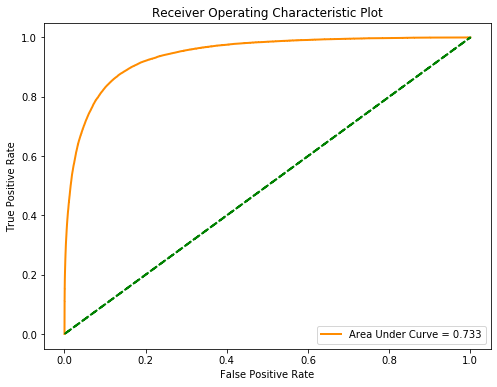

In [25]:
roc_curve_plot(y_val, clf_tf.predict_proba(X_val_tf), clf_tf.predict(X_val_tf))

### Inspection
Now lets look at the confusion matrix and feature importance to better understand our model

[[327385   4512]
 [ 15115  13963]]


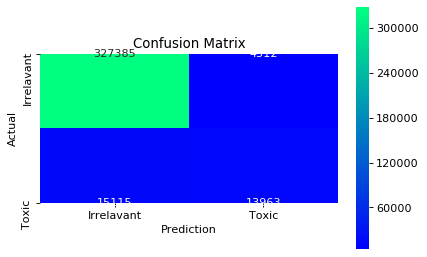

In [26]:
make_confusion_matrix(y_val, clf_tf.predict(X_val_tf))

As we saw of our visualization in 2 dimensions the two classes weren't well separated so it makes sense our model is having a hard time classifying.  Let's see what words it is saying are the most important when for classifying.  It classified about 3000 more comments correctly than the previous model and missclassified 2000 less.  So overall our model is doing better 

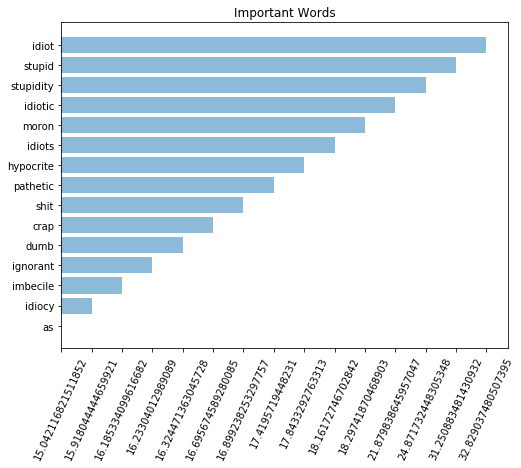

In [27]:
most_important_words(tf, clf_tf, 15)

Our model does seem to be picking up on the right words but these are probably the most frequently used words that are classified as toxic. Our weights are a lot higher meaning the correct words associated with toxicity are being picked up better. Our model is overfitting for the word 'as' because obviously that word isn't toxic and should not be there.  Also, I'm sure there are a lot of worse words our model is not picking up on that it should be since this is an online comments dataset.  

## Word2Vec
Let's see if we can improve our model by using a different type of embeddings. Word2Vec helps capture semantic meaning between words e.g. 'happy' and 'positive' will be closer to each other than 'nice' and 'dog' would.  We will use Google's pretrained Word2Vec model and run the following steps
1. Word2Vec Embeddings
2. Dimensionality Reduction (LSA)
3. Logistic Regression

### Word2Vec Embeddings
To create Word2Vec Embeddings for our comments we are going to average the Word2Vec scores for all our words in each comment

In [28]:
import gensim
from gensim.models import KeyedVectors

google_vec_file = '/Users/luken2/Downloads/GoogleNews-vectors-negative300.bin.gz'

Word2Vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [29]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df, generate_missing=False):
    embeddings = df['lemmatized'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                        generate_missing=generate_missing))
    return list(embeddings)

In [30]:
embeddings = get_word2vec_embeddings(Word2Vec, df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, y, test_size=0.2, random_state=42)

### Dimensionality Reduction (LSA)
For visualization we use LSA and it seems to be not much of a difference in separation between the two classes

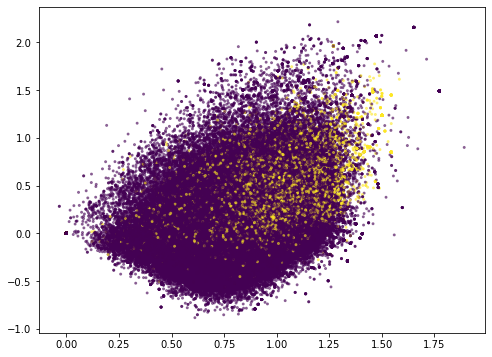

In [31]:
plot_lsa(X_train_word2vec, y_train_word2vec)

### Logistic Regression
Let's fit another model and evaluate it

In [32]:
clf2 = LogisticRegression(C=3, solver='sag', n_jobs=-1, random_state=42)
clf2.fit(X_train_word2vec, y_train_word2vec)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [33]:
evaluate_model(y_test_word2vec, clf2.predict(X_test_word2vec))

Accuracy:  0.9223907472816677
Precision:  0.5706875914350312
Recall:  0.14756860857005297
f1_score:  0.23450009563625435


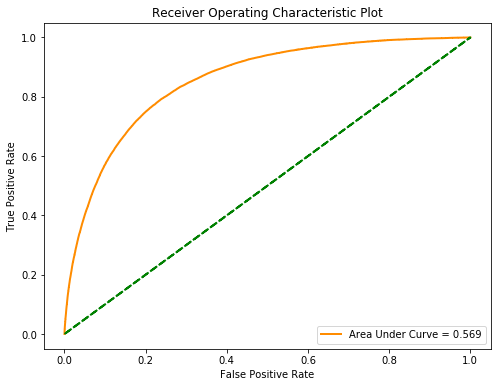

In [34]:
roc_curve_plot(y_test_word2vec, clf2.predict_proba(X_test_word2vec),
               clf2.predict(X_test_word2vec))

The Word2Vec embeddings seemed to do substantially worse than CountVectorizer and TL-IDF embeddings.  This might be because most of the words in our vocab aren't in Google's pretrained Word2Vec model.  It is not likely Google used a vocab list with how people talk in anonymous comments.  If we want to use Word2Vec we're going to have to train our own model on all our comments. I'm not going to futher inspect this model.

## Random Oversampling
Since our classes are imbalanced it will probably be helpful to do some kind of oversampling/undersampling.  However, since our dataset is so large, oversampling techniques like SMOTE or ADYSON will take a long time to fit.  So since im short on time I decided to use Random Oversampling to deal with the class imbalance.  We'll use our best pipeline yet and judge the results
1. Embeddings (TF-IDF)
2. Random Oversampling
3. Logistic Regression
4. Inspection

### Random Oversampling
We already have our TF-IDF embeddings from above so we can go straight to random oversampling

In [35]:
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [36]:
ros = RandomOverSampler(random_state=42)
X_train_tf_ros, y_train_ros = ros.fit_sample(X_train_tf, y_train)

### Logistic Regression
Let's perform a quick logistic regression.  Our accuracy and f1_score went down a little.  Precision and Recall basically switched values and AUC score went up.  It seems by random oversampling we gain recall and lose precision.  We are going to need to inspect further into the model to see if we can agree with it more

In [37]:
clf_tf_ros = LogisticRegression(C=3, solver='sag', n_jobs=-1, random_state=42)
clf_tf_ros.fit(X_train_tf_ros, y_train_ros)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [38]:
evaluate_model(y_val, clf_tf_ros.predict(X_val_tf))

Accuracy:  0.9025251056167325
Precision:  0.4420910918123554
Recall:  0.801808927711672
f1_score:  0.569937420553437


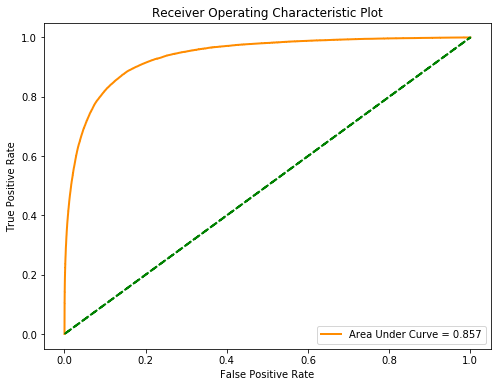

In [39]:
roc_curve_plot(y_val, clf_tf_ros.predict_proba(X_val_tf),
               clf_tf_ros.predict(X_val_tf))

### Inspection
To see if our model is performing better we need to look more into it. Our scores Don't mean too much when some are decreasing and others are increasing.

[[302474  29423]
 [  5763  23315]]


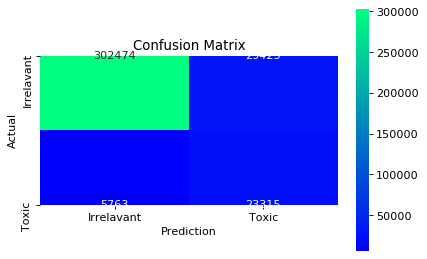

In [40]:
make_confusion_matrix(y_val, clf_tf_ros.predict(X_val_tf))

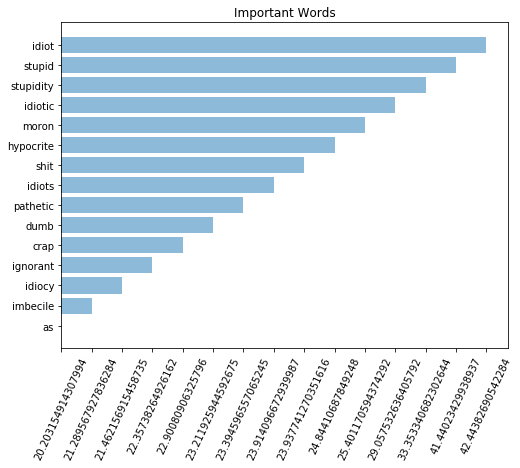

In [41]:
most_important_words(tf, clf_tf_ros, 15)

So it seems our model is classifying correctly most of the toxic comments but at the expense of misclassifying a lot of non-toxic comments too.  This could be a bias in the model for when certain words are used to refer towards marginalized groups that in fact don't imply a negative connatation. The most important words seem to be the same as without random oversampling.  Depending on the business model one might be better than the other

## Neural Networks
We are going to train two neural nets.  One with pre-trained embeddings and one without.  To utilize keras we are going to need to preprocess again and make new embeddings for our text.  We will use Word2Vec's google library again but you can also use Glove or FastText.  Or all three! 


In [42]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input, Embedding, Bidirectional, LSTM
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D

In [53]:
# number of dimensions in Word2Vec
sequence_length = 100
vocab_size = len(vocab)

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['comment_text'])

X_train_val_cnn = tokenizer.texts_to_sequences(X_train_val)
X_train_val_cnn = pad_sequences(X_train_val_cnn, maxlen=sequence_length)
                      
X_test_cnn = tokenizer.texts_to_sequences(X_test)
X_test_cnn = pad_sequences(X_test_cnn, maxlen=sequence_length)

In [45]:
embedding_dim = 300

word_index = tokenizer.word_index


embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, index in word_index.items():
    if word in Word2Vec:
        embedding_matrix[index, :] = Word2Vec[word]
    else:
        np.random.rand(embedding_dim)
print(embedding_matrix.shape)

(662639, 300)


### Bi-Directional LSTM 
Our first model is going to be a Bi-Directional LSTM.  They have been proven to work well with classifications on text data.  We will train 6 epochs here and see how well it performs

In [ ]:
inp = Input(shape=(sequence_length,)) # must specify format of input layer
x = Embedding(vocab_size, embedding_dim)(inp) # model learns its own word embeddings
x = Bidirectional(LSTM(8, recurrent_dropout=.3))(x) # bi-LSTM with regularization
y = Dense(1, activation='sigmoid')(x)

NN = Model(inp, y)
NN.summary()

In [ ]:
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = NN.fit(X_train_val_cnn, y_train, 
                 validation_data=(X_val_cnn, y_val),
                 epochs=2, batch_size=512, verbose=1)

Seems our model overfitted here.  This could be from running too many epochs or other reasons unknown.  However the computation cost for this model is too high so I am not going to rerun it with different parameters.  

In [ ]:
evaluate_model(y_val, (NN.predict(X_val_cnn)[:,0] > .5).astype(int))

In [ ]:
make_confusion_matrix(y_val, (NN.predict(X_val_cnn)[:,0] > .5).astype(int))

Our evaluation is about the same if not worse than a simple logistic regression

### Bi-Directional LSTM Word2Vec Embeddings 
Now let's run the same model but with Word2Vec embeddings.  This means we are going to embed all our words in google's word2vec vocabulary with their word vectors and have our model learn the rest. Our vocab has just shy of 200 million words that were in google's vocab.  This leaves our model only roughly 200,000 embeddings to train

In [46]:
embedding_dim1=300

inp1 = Input(shape=(sequence_length,))
x1 = Embedding(len(word_index) + 1,
              embedding_dim1,
              weights=[embedding_matrix], # where we feed the pretrained vecs
              trainable=False)(inp1) # freeze these parameters in the model

x1 = Bidirectional(LSTM(64, recurrent_dropout=.1))(x1)
x1 = Dense(32)(x1) # fully connected layer on top of the output of the bi-LSTM
x1 = Dropout(.3)(x1)
y1 = Dense(1, activation='sigmoid')(x1)

NN2 = Model(inp1, y1)
NN2.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          198791700 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dens

In [54]:
NN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = NN2.fit(X_train_val_cnn, y_train_val, 
                 validation_data=(X_test_cnn, y_test),
                 epochs=6, batch_size=512, verbose=1)

Train on 1443899 samples, validate on 360975 samples
Epoch 1/6
1443899/1443899 [==============================] - 2576s 2ms/step - loss: 0.1348 - acc: 0.9482 - val_loss: 0.1362 - val_acc: 0.9473
Epoch 2/6
1443899/1443899 [==============================] - 2552s 2ms/step - loss: 0.1313 - acc: 0.9493 - val_loss: 0.1335 - val_acc: 0.9485
Epoch 3/6
1443899/1443899 [==============================] - 2525s 2ms/step - loss: 0.1285 - acc: 0.9500 - val_loss: 0.1331 - val_acc: 0.9486
Epoch 4/6
1443899/1443899 [==============================] - 2529s 2ms/step - loss: 0.1263 - acc: 0.9509 - val_loss: 0.1340 - val_acc: 0.9483
Epoch 5/6
1443899/1443899 [==============================] - 2540s 2ms/step - loss: 0.1243 - acc: 0.9516 - val_loss: 0.1323 - val_acc: 0.9484
Epoch 6/6
1443899/1443899 [==============================] - 2538s 2ms/step - loss: 0.1223 - acc: 0.9521 - val_loss: 0.1350 - val_acc: 0.9481


In [55]:
evaluate_model(y_test, (NN2.predict(X_test_cnn)[:,0] > .5).astype(int))

Accuracy:  0.9481293718401551
Precision:  0.7895413870246085
Recall:  0.48548730999380973
f1_score:  0.6012607010520039


[[328134   3763]
 [ 14961  14117]]


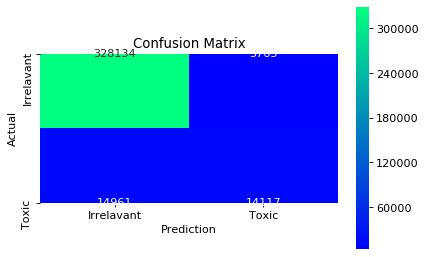

In [57]:
make_confusion_matrix(y_test, (NN2.predict(X_test_cnn)[:,0] > .5).astype(int))

To make an ROC Curve with Keras models we have to use a different function

In [58]:
from sklearn.metrics import auc
y_pred_keras = NN2.predict(X_test_cnn).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

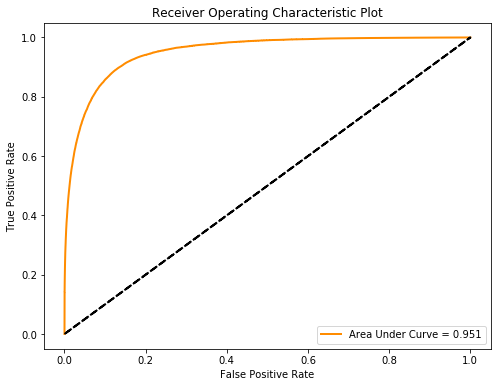

<Figure size 432x288 with 0 Axes>

In [59]:
lw = 2
plt.figure(figsize=(8, 6))
plt.plot(fpr_keras, tpr_keras, color='darkorange', lw=lw, label='Area Under Curve = %0.3f' % auc_keras)
plt.plot(y_test, y_test, color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc_curve_keras.png')

This is our best model yet.  Utilizing Word2Vec embeddings with LSTM was well worth it.  Only thing is with neural nets it is hard to see exactly what words our model is using to make predictions through the dimensionality reduction within it's layers.  So to fully understand if our model is making informative decisions we'll have to look at some examples 